## References
- **[Calculate indicators](#Calculate-indicators)**
    - [Return](#Return)
    - [RSI](#RSI)
    - [Gain/lose](#Gain/lose)
    - [Average gain/loss](#Average-gain/loss)
    - [MA](#MA)
    - [Moving Average Convergence Divergence (MACD)](#Moving-Average-Convergence-Divergence-(MACD))
    - [Stochastic Oscillator](#Stochastic-Oscillator)
    - [Williams %R ('r_percent')](#Williams-%R-('r_percent'))
    - [Bollinger Bands](#Bollinger-Bands)
    
    
- **[Fuzzyfication and backtesting](#Fuzzyfication-and-backtesting)**
    - [RSI](#RSI-decision)
        - [RSI backtesting](#RSI-backtesting)
    - [Williams %R ('r_percent')](#Williams-%R-('r_percent'))
        - [Williams backtesting](#Williams-backtesting)
     - [MA](#MA-decision)
        - [MA backtesting](#MA-backtesting)
    - [MACD](#MACD-decision)
        - [MACD backtesting](#MACD-backtesting)


    
   


***

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import glob
import os
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import plotly.express as px
import simpful as sf
from simpful import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import SignalStrategy

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "MAGISTERKA"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="jpg", resolution=400):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Data download

In [27]:
stocks = ['EURUSD=X', '^GSPC']

start_data = '2018-02-01'  # (RRR-MM-DD)
end_data = '2024-02-01'  # (RRR-MM-DD)

for stock in stocks:
    data = yf.download(stock, start_data, end_data)
    df = pd.DataFrame(data)
    df['Name'] = stock  # add column with symbol
    df.to_csv(stock + '.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#### Load data

In [76]:
data = pd.read_csv('EURUSD=X.csv')

In [77]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2018-02-01,1.241742,1.248782,1.238651,1.241866,1.241866,0,EURUSD=X
1,2018-02-02,1.251267,1.251799,1.241188,1.251001,1.251001,0,EURUSD=X
2,2018-02-05,1.244710,1.247816,1.240156,1.244694,1.244694,0,EURUSD=X
3,2018-02-06,1.236828,1.242854,1.231618,1.236782,1.236782,0,EURUSD=X
4,2018-02-07,1.238145,1.240325,1.227853,1.238129,1.238129,0,EURUSD=X


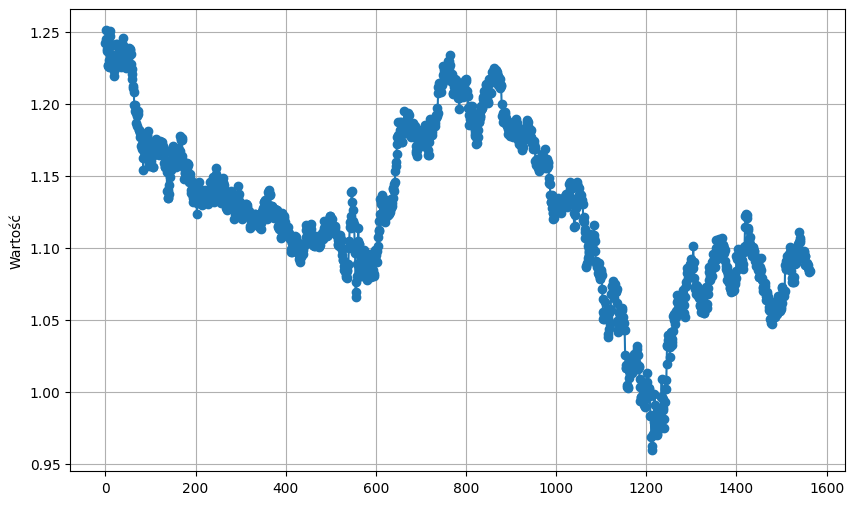

In [78]:
plt.figure(figsize=(10, 6)) 
plt.plot(data.index, data['Close'], marker='o') 
plt.ylabel('Wartość') 
plt.grid(True) 
plt.show()

# Calculate indicators

# Return

In [79]:
price_data = data

In [80]:
# Identify rows where the symbol changes
mask = price_data['Name'] != price_data['Name'].shift(1)

# Calculate log return
price_data['Return'] = np.log(price_data['Close']) -  np.log(price_data['Close'].shift(1))

# For rows where symbol changes set null
price_data['Return'] = np.where(mask == True, np.nan, price_data['Return'])


# Gain/lose


In [81]:
# Set '0' if 'Up' is below 0
price_data['Up'] = price_data['Return']
price_data.loc[(price_data['Up']<0), 'Up'] = 0
 
# Set '0' if 'Down' above 0
price_data['Down'] = price_data['Return']
price_data.loc[(price_data['Down']>0), 'Down'] = 0 
 
# Set the absolute value for negative values
price_data['Down'] = abs(price_data['Down'])

# Average gain/loss

In [82]:
# 14-days averages
price_data['avg_14up'] = price_data.groupby('Name')['Up'].transform(lambda x: x.rolling(window=14).mean())
price_data['avg_14down'] = price_data.groupby('Name')['Down'].transform(lambda x: x.rolling(window=14).mean())


# RSI

In [83]:
# Calculate RS

price_data['RS_14'] = price_data['avg_14up'] / price_data['avg_14down']

# Calculate RSI

price_data['RSI'] = 100 - (100/(1 + price_data['RS_14']))

# MA

In [84]:
price_data["5MA"] = price_data.groupby('Name')['Close'].transform(lambda x: x.rolling(window = 5).mean())
price_data["15MA"] = price_data.groupby('Name')['Close'].transform(lambda x: x.rolling(window = 15).mean())

# Moving Average Convergence Divergence (MACD)

In [85]:
# Calculate 12 and 26 EWM
price_data['12Ewm'] = price_data.groupby('Name')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
price_data['26Ewm'] = price_data.groupby('Name')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

# Calculate MACD
price_data['MACD'] = price_data['12Ewm'] - price_data['26Ewm']


# Stochastic Oscillator

In [86]:
# Period
n = 14

# Group by the symbol and then take max and min 
price_data['low_14'] = price_data.groupby('Name')['Low'].transform(lambda x: x.rolling(window = n).min())
price_data['high_14'] = price_data.groupby('Name')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate the stochastic oscillator
price_data['k_percent']  = 100 * ((price_data['Close'] - price_data['low_14']) / (price_data['high_14'] - price_data['low_14']))

# Williams %R ('r_percent')

In [87]:
# Period
n = 14

# Calculate Williams %R
price_data['r_percent'] = -100 * ((price_data['high_14'] - price_data['Close']) / (price_data['high_14'] - price_data['low_14']))



# Bollinger Bands
[Bollinger Bands](https://tcoil.info/compute-bollinger-bands-for-stocks-with-python-and-pandas/)

In [88]:
def bollinger_bands(df, n, m):
    result = df.copy()  
    
    # Initialize new columns with NaN values
    result['B_MA'] = np.nan
    result['BU'] = np.nan
    result['BL'] = np.nan
    
    grouped = df.groupby('Name')
    
    for name, group in grouped:
        data = group['Close']
        
        B_MA = data.rolling(n, min_periods=n).mean()
        sigma = data.rolling(n, min_periods=n).std()
        
        BU = B_MA + m * sigma
        BL = B_MA - m * sigma
        
        # Assign calculated values to the corresponding rows in the result DataFrame
        result.loc[group.index, 'B_MA'] = B_MA
        result.loc[group.index, 'BU'] = BU
        result.loc[group.index, 'BL'] = BL
    
    return result

In [89]:
n = 15   # datapoint rolling window
m = 2    # sigma width
df = bollinger_bands(price_data, 20, 2)

In [90]:
df.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume,Name,Return,Up,...,12Ewm,26Ewm,MACD,low_14,high_14,k_percent,r_percent,B_MA,BU,BL
0,2018-02-01,1.241742,1.248782,1.238651,1.241866,1.241866,0,EURUSD=X,NaN,NaN,...,1.241866,1.241866,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-02-02,1.251267,1.251799,1.241188,1.251001,1.251001,0,EURUSD=X,0.007329,0.007329,...,1.243271,1.242543,0.000729,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-02-05,1.244710,1.247816,1.240156,1.244694,1.244694,0,EURUSD=X,-0.005054,0.000000,...,1.243490,1.242702,0.000788,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-02-06,1.236828,1.242854,1.231618,1.236782,1.236782,0,EURUSD=X,-0.006377,0.000000,...,1.242458,1.242263,0.000195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-02-07,1.238145,1.240325,1.227853,1.238129,1.238129,0,EURUSD=X,0.001089,0.001089,...,1.241792,1.241957,-0.000165,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-02-08,1.226843,1.229453,1.221658,1.226813,1.226813,0,EURUSD=X,-0.009182,0.000000,...,1.239488,1.240835,-0.001348,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-02-09,1.226076,1.228547,1.222643,1.226076,1.226076,0,EURUSD=X,-0.000601,0.000000,...,1.237424,1.239742,-0.002318,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2018-02-12,1.225340,1.229710,1.223631,1.225280,1.225280,0,EURUSD=X,-0.000650,0.000000,...,1.235556,1.238671,-0.003115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-02-13,1.230118,1.237200,1.228607,1.230376,1.230376,0,EURUSD=X,0.004150,0.004150,...,1.234759,1.238056,-0.003297,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2018-02-14,1.235300,1.241619,1.227853,1.235376,1.235376,0,EURUSD=X,0.004056,0.004056,...,1.234854,1.237858,-0.003004,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
print('Before NaN Drop we have {} rows and {} columns'.format(df.shape[0], df.shape[1]))

# Delete lines with NaN values
df = df.dropna()

# Display how much we have left now
print('After NaN Drop we have {} rows and {} columns'.format(df.shape[0], df.shape[1]))


Before NaN Drop we have 1564 rows and 27 columns
After NaN Drop we have 1545 rows and 27 columns


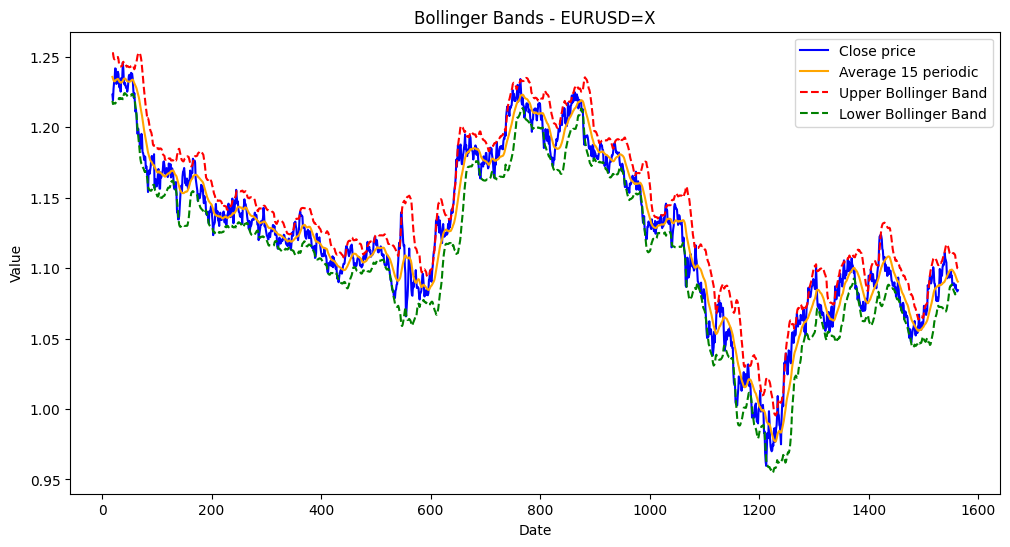

In [92]:
grouped = df.groupby('Name')

for name, group in grouped:
    plt.figure(figsize=(12, 6))
    plt.title(f'Bollinger Bands - {name}')
    
    plt.plot(group.index, group['Close'], label='Close price', color='blue') 
    plt.plot(group.index, group['B_MA'], label=f'Average {n} periodic', color='orange')  
    plt.plot(group.index, group['BU'], label=f'Upper Bollinger Band', color='red', linestyle='--') 
    plt.plot(group.index, group['BL'], label=f'Lower Bollinger Band', color='green', linestyle='--') 
   
    plt.legend()  
    plt.xlabel('Date') 
    plt.ylabel('Value') 
    plt.show()

## Export file

In [93]:
# df.to_csv("indicators_eurusd_d.csv", index=False, encoding='utf-8-sig')

## [References](#References)

***

# Fuzzyfication and backtesting

***

## RSI decision


In [94]:
data = df

In [95]:
def decision_rsi(df):
    df['dec_rsi'] = 'HOLD'  

    df.loc[df['RSI'] < 30, 'dec_rsi'] = 'BUY'
    df.loc[df['RSI'] > 70, 'dec_rsi'] = 'SELL'

    return df

In [96]:
decision_rsi(data)
data['dec_rsi'].value_counts()

dec_rsi
HOLD    1216
BUY      190
SELL     139
Name: count, dtype: int64

In [97]:
FS = sf.FuzzySystem()


# linguistic variable for the input
S1 = sf.FuzzySet(points=[[0, 1.], [30, 1.], [50, 0.]], term="low")
S2 = sf.FuzzySet(points=[[50, 1.], [51, 1.], [61, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[61, 0.], [70, 1.], [100, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 100])
FS.add_linguistic_variable("RSI", LV)


# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="BUY")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="SELL")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_RSI_fuzz_system", LV)


R1 = "IF (RSI IS low) THEN (Signal_RSI_fuzz_system IS SELL)"
R2 = "IF (RSI IS medium) THEN (Signal_RSI_fuzz_system IS HOLD)"
R3 = "IF (RSI IS high) THEN (Signal_RSI_fuzz_system IS BUY)"
FS.add_rules([R1, R2, R3])

data['Signal_RSI_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['RSI']):
    FS.set_variable("RSI", value)
    decision = FS.Mamdani_inference()['Signal_RSI_fuzz_system']
    
    if decision <= 0.3:
        data.loc[data.index[i], 'Signal_RSI_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        data.loc[data.index[i], 'Signal_RSI_fuzz_system'] = 'BUY'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



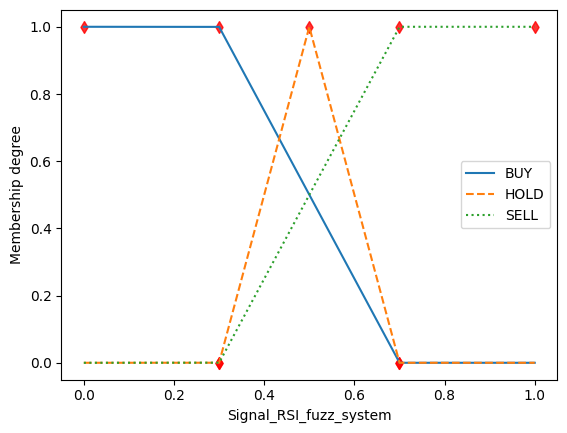

In [98]:
FS.plot_variable('Signal_RSI_fuzz_system')

In [99]:
data['Signal_RSI_fuzz_system'].value_counts()

Signal_RSI_fuzz_system
HOLD    1125
BUY      211
SELL     209
Name: count, dtype: int64

## RSI backtesting

## Sharp

In [100]:
# zmiana na datę i ustaw jako index
data = data.set_index(pd.DatetimeIndex(data['Date']))
# zmiana decyzji na -1, 0, 1
data['dec_rsi'] = data['dec_rsi'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

In [101]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['dec_rsi'])

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                   97.022654
Equity Final [$]                  9999.088085
Equity Peak [$]                       10000.0
Return [%]                          -0.009119
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -0.001487
Volatility (Ann.) [%]                0.000794
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.009125
Avg. Drawdown [%]                   -0.009125
Max. Drawdown Duration     2100 days 00:00:00
Avg. Drawdown Duration     2100 days 00:00:00
# Trades                                  327
Win Rate [%]                        34.556575
Best Trade [%]                       3.345059
Worst Trade [%]                     -4.160291
Avg. Trade [%]                    

## Fuzzy

In [102]:
# zmiana decyzji na -1, 0, 1
data['Signal_RSI_fuzz_system'] = data['Signal_RSI_fuzz_system'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})


class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        
        self.set_signal(data['Signal_RSI_fuzz_system'])
      
    
    #    size = 0.5  
     #   if self.set_signal == 1:
      #      self.buy(size=size)
       # elif self.set_signal == -1:
        #    self.sell(size=size)
       # super().next()
        
# dodać warunki zmieniające size
# set signal dodac rozmiar wejscia
bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                   97.087379
Equity Final [$]                  9999.085855
Equity Peak [$]                       10000.0
Return [%]                          -0.009141
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -0.001491
Volatility (Ann.) [%]                0.000797
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.009422
Avg. Drawdown [%]                   -0.009422
Max. Drawdown Duration     2101 days 00:00:00
Avg. Drawdown Duration     2101 days 00:00:00
# Trades                                  418
Win Rate [%]                        36.124402
Best Trade [%]                       2.784302
Worst Trade [%]                     -4.588674
Avg. Trade [%]                    

# Williams %R ('r_percent')


In [103]:
def decision_williams(df):
    df['dec_will'] = 'HOLD'  

    df.loc[df['r_percent'] < -80, 'dec_will'] = 'BUY'
    df.loc[df['r_percent'] > -20, 'dec_will'] = 'SELL'

    return df

In [104]:
data.columns.tolist()

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'Name',
 'Return',
 'Up',
 'Down',
 'avg_14up',
 'avg_14down',
 'RS_14',
 'RSI',
 '5MA',
 '15MA',
 '12Ewm',
 '26Ewm',
 'MACD',
 'low_14',
 'high_14',
 'k_percent',
 'r_percent',
 'B_MA',
 'BU',
 'BL',
 'dec_rsi',
 'Signal_RSI_fuzz_system']

In [105]:
decision_williams(data)
data['dec_will'].value_counts()

dec_will
HOLD    961
BUY     323
SELL    261
Name: count, dtype: int64

In [109]:
FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-100, 1.], [-80, 1.], [-50, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-50, 1.], [-49, 1.], [-39, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[-39, 0.], [-20, 1.], [0, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-100, 0])
FS.add_linguistic_variable("r_percent", LV)


# linguistic variable for the output
# 0-0.3 = SELL, 0.5-0.7 = HOLD, 0.7-1 = BUY
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="BUY")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="SELL")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("Signal_william_fuzz_system", LV)


R1 = "IF (r_percent IS low) THEN (Signal_william_fuzz_system IS SELL)"
R2 = "IF (r_percent IS medium) THEN (Signal_william_fuzz_system IS HOLD)"
R3 = "IF (r_percent IS high) THEN (Signal_william_fuzz_system IS BUY)"
FS.add_rules([R1, R2, R3])

data['Signal_william_fuzz_system'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['r_percent']):
    FS.set_variable("r_percent", value)
    decision = FS.Mamdani_inference()['Signal_william_fuzz_system']
    
    if decision <= 0.3:
        data.loc[data.index[i], 'Signal_william_fuzz_system'] = 'SELL'
    elif decision >= 0.7:
        data.loc[data.index[i], 'Signal_william_fuzz_system'] = 'BUY'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



# Williams backtesting

### Sharp

In [106]:
# zmiana decyzji na -1, 0, 1
data['dec_will'] = data['dec_will'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})


class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        
        self.set_signal(data['dec_will'])
      

        
# dodać warunki zmieniające size
# set signal dodac rozmiar wejscia
bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                    99.87055
Equity Final [$]                  9998.770631
Equity Peak [$]                  10000.019467
Return [%]                          -0.012294
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -0.002005
Volatility (Ann.) [%]                0.000795
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.012488
Avg. Drawdown [%]                   -0.004254
Max. Drawdown Duration     2108 days 00:00:00
Avg. Drawdown Duration      720 days 00:00:00
# Trades                                  583
Win Rate [%]                        36.878216
Best Trade [%]                       5.366104
Worst Trade [%]                     -3.767166
Avg. Trade [%]                    

### Fuzzy

In [112]:
data['Signal_william_fuzz_system'].value_counts()

Signal_william_fuzz_system
HOLD    780
SELL    405
BUY     360
Name: count, dtype: int64

In [114]:
data['Signal_william_fuzz_system'] = data['Signal_william_fuzz_system'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['Signal_william_fuzz_system'])

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                    99.87055
Equity Final [$]                    9998.2861
Equity Peak [$]                  10000.012082
Return [%]                          -0.017139
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -0.002796
Volatility (Ann.) [%]                0.000797
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                    -0.01726
Avg. Drawdown [%]                   -0.008642
Max. Drawdown Duration     2156 days 00:00:00
Avg. Drawdown Duration     1080 days 00:00:00
# Trades                                  764
Win Rate [%]                        35.732984
Best Trade [%]                       4.900268
Worst Trade [%]                     -3.610325
Avg. Trade [%]                    

# MA decision



kupno - krótsza przecina dłuższą od dołu 

sprzedaż - krótsza przecina dłuższą od góry


In [116]:
# Ostre

data['prev_5MA'] = data['5MA'].shift(1)

data['crossover'] = np.where((data['5MA'] > data['15MA']) & (data['prev_5MA'] < data['15MA']), 'bullish crossover',
                                  np.where((data['5MA'] < data['15MA']) & (data['prev_5MA'] > data['15MA']), 'bearish crossover', None))

data['cross_MA'] = np.where(data['crossover'] == 'bullish crossover', 'BUY', 
                                          np.where(data['crossover'] == 'bearish crossover', 'SELL', 'HOLD'))

data['crossover'].value_counts()



crossover
bearish crossover    78
bullish crossover    68
Name: count, dtype: int64

In [118]:
# Calculating the difference between the shorter and longer average

data['diff_MA'] = data['5MA'] - data['15MA']

# Creation of 1 lagged column with difference in averages
data['diff_MA_prev'] = data['diff_MA'].shift(1)

data['diff_MA'].describe()

count    1545.000000
mean       -0.000481
std         0.007046
min        -0.029886
25%        -0.005046
50%        -0.000461
75%         0.003504
max         0.026677
Name: diff_MA, dtype: float64

In [119]:
'''
Ustalenie wartości 'małe', 'duże' na podstawie róznicy między średnimi
i je opóźnionej wartości oraz podjęcie decyzji 'BUY', 'SELL'.
Jeśli diff_MA około 0 i diff_MA_prev < 0 - BUY
Jeśli diff_MA około 0 i diff_MA_prev > 0 - SELL
'''

FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [-0.001, 1.], [0, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-0.001, 0.], [0, 1.], [0.001, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[0, 0.], [0.001, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_MA", LV)
FS.add_linguistic_variable("diff_MA_prev", LV)


# linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("fuzz_MA_strategy", LV)

R1 = "IF (diff_MA IS medium) AND (diff_MA_prev IS low) THEN (fuzz_MA_strategy IS BUY)"
R2 = "IF (diff_MA IS medium) AND (diff_MA_prev IS high) THEN (fuzz_MA_strategy IS SELL)"
R3 = "IF (diff_MA IS low) THEN (fuzz_MA_strategy IS HOLD)"
R4 = "IF (diff_MA IS high) THEN (fuzz_MA_strategy IS HOLD)"
FS.add_rules([R1, R2, R3, R4])


data['fuzz_MA_strategy'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['diff_MA']):
    FS.set_variable("diff_MA", value)
    FS.set_variable("diff_MA_prev", data.loc[data.index[i], 'diff_MA_prev'])
    decision = FS.Mamdani_inference()['fuzz_MA_strategy']

    if decision <= 0.3:
        data.loc[data.index[i], 'fuzz_MA_strategy'] = 'BUY'
    elif decision >= 0.7:
        data.loc[data.index[i], 'fuzz_MA_strategy'] = 'SELL'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



In [120]:
data['fuzz_MA_strategy'].value_counts()

fuzz_MA_strategy
HOLD    1492
BUY       27
SELL      26
Name: count, dtype: int64

# MA backtesting

## Sharp

In [121]:
data['cross_MA'] = data['cross_MA'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['cross_MA'])
        

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                   98.964401
Equity Final [$]                  9999.571229
Equity Peak [$]                  10000.049287
Return [%]                          -0.004288
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -0.000699
Volatility (Ann.) [%]                0.000797
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.005675
Avg. Drawdown [%]                   -0.000695
Max. Drawdown Duration     2072 days 00:00:00
Avg. Drawdown Duration      237 days 00:00:00
# Trades                                  145
Win Rate [%]                        32.413793
Best Trade [%]                        4.91431
Worst Trade [%]                      -2.92273
Avg. Trade [%]                    

## Fuzzy

In [122]:
data['fuzz_MA_strategy'] = data['fuzz_MA_strategy'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['fuzz_MA_strategy'])
        
# dodać warunki zmieniające size
# set signal dodac rozmiar wejscia
bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                   97.411003
Equity Final [$]                   9999.99661
Equity Peak [$]                       10000.0
Return [%]                          -0.000034
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -0.000006
Volatility (Ann.) [%]                0.000787
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.002339
Avg. Drawdown [%]                   -0.002339
Max. Drawdown Duration     2108 days 00:00:00
Avg. Drawdown Duration     2108 days 00:00:00
# Trades                                   52
Win Rate [%]                        46.153846
Best Trade [%]                      10.304178
Worst Trade [%]                     -6.591538
Avg. Trade [%]                    

# MACD decision

In [123]:
   '''
    Linia MACD przetnie od dołu linię sygnałową - kup
    Linia MACD przetnie od góry linię sygnałową - sprzedaj
    '''
    
data['Signal_Line'] = data.groupby('Name')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())

buy_condition = ((data['MACD'].shift(1) < data['Signal_Line'].shift(1)) & 
                 (data['MACD'] > data['Signal_Line']))  
               

sell_condition = ((data['MACD'].shift(1) > data['Signal_Line'].shift(1)) & 
                  (data['MACD'] < data['Signal_Line']))

data['MACD_decision'] = np.where(buy_condition, 1, np.where(sell_condition, -1, 0))

data[['MACD', 'Signal_Line']].describe()

,MACD,Signal_Line
count,1545.000000,1545.000000
mean,-0.000665,-0.000669
std,0.005181,0.004879
min,-0.014496,-0.012347
25%,-0.003936,-0.003662
50%,-0.001198,-0.001303
75%,0.002173,0.001982
max,0.014898,0.013506


In [124]:
# Calculating the difference between MACD and Signal line
data['diff_MACD'] = data['MACD'] - data['Signal_Line']

# Creation of 1 lagged column with the difference in MACD and Signal
data['diff_MACD_prev'] = data['diff_MACD'].shift(1)

In [128]:
'''
Ustalenie wartości 'małe', 'duże' na podstawie róznicy między średnimi
i je opóźnionej wartości oraz podjęcie decyzji 'BUY', 'SELL'.
Jeśli diff_MACD około 0 (0,001) i diff_MACD_prev < 0 - BUY
Jeśli diff_MACD około 0(0,001) i diff_MACD_prev > 0 - SELL
'''

FS = sf.FuzzySystem()

# linguistic variable for the input
S1 = sf.FuzzySet(points=[[-1, 1.], [-0.001, 1.], [0, 0.]], term="low")
S2 = sf.FuzzySet(points=[[-0.001, 0.], [0, 1.], [0.001, 0.]], term="medium")
S3 = sf.FuzzySet(points=[[0, 0.], [0.001, 1.], [1, 1.]], term="high")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[-1, 1])
FS.add_linguistic_variable("diff_MACD", LV)
FS.add_linguistic_variable("diff_MACD_prev", LV)


# linguistic variable for the output
S1 = sf.FuzzySet(points=[[0, 1.], [0.3, 1.], [0.7, 0.]], term="SELL")
S2 = sf.FuzzySet(points=[[0.3, 0.], [0.5, 1.], [0.7, 0.]], term="HOLD")
S3 = sf.FuzzySet(points=[[0.3, 0.], [0.7, 1.], [1.0, 1.]], term="BUY")
LV = sf.LinguisticVariable([S1, S2, S3], universe_of_discourse=[0, 1])
FS.add_linguistic_variable("fuzz_MACD_strategy", LV)

R1 = "IF (diff_MACD IS medium) AND (diff_MACD_prev IS low) THEN (fuzz_MACD_strategy IS BUY)"
R2 = "IF (diff_MACD IS medium) AND (diff_MACD_prev IS high) THEN (fuzz_MACD_strategy IS SELL)"
R3 = "IF (diff_MACD IS low) THEN (fuzz_MACD_strategy IS HOLD)"
R4 = "IF (diff_MACD IS high) THEN (fuzz_MACD_strategy IS HOLD)"
FS.add_rules([R1, R2, R3, R4])


data['fuzz_MACD_strategy'] = 'HOLD' 

# generate signals
for i, value in enumerate(data['diff_MACD']):
    FS.set_variable("diff_MACD", value)
    FS.set_variable("diff_MACD_prev", data.loc[data.index[i], 'diff_MACD_prev'])
    decision = FS.Mamdani_inference()['fuzz_MACD_strategy']

    if decision <= 0.3:
        data.loc[data.index[i], 'fuzz_MACD_strategy'] = 'BUY'
    elif decision >= 0.7:
        data.loc[data.index[i], 'fuzz_MACD_strategy'] = 'SELL'

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)



# MACD backtesting

### Sharp

In [125]:
class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['MACD_decision'])
        

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                   98.964401
Equity Final [$]                  9999.634439
Equity Peak [$]                   10000.03406
Return [%]                          -0.003656
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -0.000596
Volatility (Ann.) [%]                0.000794
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.004962
Avg. Drawdown [%]                   -0.001099
Max. Drawdown Duration     2072 days 00:00:00
Avg. Drawdown Duration      428 days 00:00:00
# Trades                                  125
Win Rate [%]                             28.8
Best Trade [%]                        4.17545
Worst Trade [%]                     -2.243889
Avg. Trade [%]                    

### Fuzzy

In [129]:
data['fuzz_MACD_strategy'] = data['fuzz_MACD_strategy'].replace({'BUY': 1, 'HOLD': 0, 'SELL': -1})

class CustomStrategy(SignalStrategy):
    def init(self):
        super().init()
        self.set_signal(data['fuzz_MACD_strategy'])
        

bt = Backtest(data, CustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging = False, exclusive_orders = True)
stats = bt.run()
bt.plot()
stats

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\backtesting\_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


Start                     2018-02-28 00:00:00
End                       2024-01-31 00:00:00
Duration                   2163 days 00:00:00
Exposure Time [%]                     99.7411
Equity Final [$]                  9999.994589
Equity Peak [$]                  10000.090799
Return [%]                          -0.000054
Buy & Hold Return [%]              -11.340024
Return (Ann.) [%]                   -0.000009
Volatility (Ann.) [%]                0.000795
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.001811
Avg. Drawdown [%]                   -0.000338
Max. Drawdown Duration      857 days 00:00:00
Avg. Drawdown Duration      119 days 00:00:00
# Trades                                   52
Win Rate [%]                        46.153846
Best Trade [%]                       8.165896
Worst Trade [%]                     -4.623008
Avg. Trade [%]                    